In [141]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
from scipy.linalg import block_diag
from scipy.linalg import eig


os.chdir('/Users/shaileshkakkar/Desktop/CryptoData/LatestData/Data/ETHBTC/')
filePath = os.getcwd() + '/PartialBookData.txt'
#print filePath
data = pd.read_csv(filePath)
data['Spread'] = 100*(data['ask1'] - data['bid1'])/data['bid1']
data['MidPrice'] = (data['ask1'] + data['bid1'])/2
data['CompositePrice'] = (data['ask1'] * data['bidVol1'] + data['bid1']*data['askVol1'])/(data['askVol1'] + data['bidVol1'])
data['MidPriceReturn'] = data['MidPrice'].pct_change()
#Convert to time stamp specifying that the time is in ms
data['LocalTime'] = data['LocalTime'].apply(lambda x : pd.to_datetime(x, unit= 'ms') )
data.index = data['LocalTime']
#Convert it into snapshot data with 1 second granularity
data = data.resample('1000L',closed = 'left', label='right', how = 'last')
#Fill all the NA values with the last observed values
data = data.ffill()

Text(0.5,1,u'Histogram of the observed spread in the pair ETHBTC')

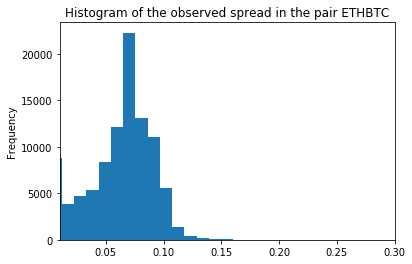

In [142]:
data['Spread'] = 100*(data['ask1'] - data['bid1'])/data['bid1']
data['Spread'].plot(kind = 'hist', bins = 21, xlim = [0.01, 0.3])
plt.title('Histogram of the observed spread in the pair ETHBTC')
plt.show()

As seen above, the spread of the currency pair remains less than 10bps most of the times. It is interesting to note, since the exchange fee for the market making( buy + sell cost) is 10 bps on Binance if the market making agent chooses to pay the fee in BNB, is is more otherwise. This points to perhaps rebate being provided to some key market maker players that is not available to others.

Also, the % of instances where there is any change in the bid or ask price is 48.41% and bid-ask crossover occurs at 3.39% of the times. 

Note that the data is sampled here with a 1 second frequency, and ETHBTC being a highly liquid pair, these numbers make sense.

In [143]:
# % of Instances where either the best bid or the best ask has moved
print 100.*sum(data['MidPriceReturn'] != 0)/len(data)

48.4110462791


In [144]:
#Percentage of events where bid-ask crossover occured
100.* sum( (data['ask1'] <= data['bid1'].shift(1)) | (data['bid1'] >= data['ask1'].shift(1)) ) / len(data)

3.3942799716972427

In [145]:
def prep_data_sym(T,n_imb,dt,n_spread,hist):
    data.rename(columns={'bid1': 'bid'}, inplace=True)
    data.rename(columns={'ask1': 'ask'}, inplace=True)
    data.rename(columns={'askVol1': 'as'}, inplace=True)
    data.rename(columns={'bidVol1': 'bs'}, inplace=True)
    data.rename(columns={'LocalTime': 'time'}, inplace=True)    
    #Removed data(last param) from the original function
    spread=T.ask-T.bid
    ticksize=np.round(min(spread.loc[spread>0])*1e6)/1e6
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2

    #filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    T['wmid']=T['imb']*T['ask']+(1-T['imb'])*T['bid']

    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)
    T['next_mid']=T['mid'].shift(-dt)
    T['next_wmid']=T['wmid'].shift(-dt)

    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)

    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T['dW']=T['next_wmid']-T['wmid']
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]

    #Getting the next step done
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['dW']=-T2['dW']
    T2['mid']=-T2['mid']
    T2['wmid']=-T2['wmid']
    T=pd.concat([T,T2])
    T.index = pd.RangeIndex(len(T.index))
    if hist<>'off':
        histogram=pd.DataFrame.hist(T, column='spread')
    return T,ticksize

In [146]:
def estimate_old(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()

    #print no_move_counts
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']<>0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']<>0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [147]:
def compute_next_price_moves(T):
    T['npm']=np.nan
    T['npm'].loc[(T['dM'] <>0)]=np.round(T['dM'].loc[(T['dM'] <>0)] /ticksize*2)*ticksize/2
    T['npm']=T['npm'].bfill()
    T = T.loc[(T.npm <= ticksize*1.1)& (T.npm>=-ticksize*1.1) ]
    T['nnpm']=np.nan
    T['nnpm'].loc[(T['dM'] <>0)]=T['dM'].loc[(T['dM'] <>0)]+T['npm'].shift(-1).loc[(T['dM'] <>0)]
    T['nnpm']=T['nnpm'].bfill()
    T = T.loc[(T.nnpm <= ticksize*2.1)& (T.nnpm>=-ticksize*2.1) ]
    T['nnnpm']=np.nan
    T['nnnpm'].loc[(T['dM'] <>0)]=T['dM'].loc[(T['dM'] <>0)]+T['nnpm'].shift(-1).loc[(T['dM'] <>0)]
    T['nnnpm']=T['nnnpm'].bfill()
    T = T.loc[(T.nnnpm <= ticksize*3.1)& (T.nnnpm>=-ticksize*3.1) ]
    T['nnnnpm']=np.nan
    T['nnnnpm'].loc[(T['dM'] <>0)]=T['dM'].loc[(T['dM'] <>0)]+T['nnnpm'].shift(-1).loc[(T['dM'] <>0)]
    T['nnnnpm']=T['nnnnpm'].bfill()
    T = T.loc[(T.nnnnpm <= ticksize*4.1)& (T.nnnnpm>=-ticksize*4.1) ]
    T['nnnnnpm']=np.nan
    T['nnnnnpm'].loc[(T['dM'] <>0)]=T['dM'].loc[(T['dM'] <>0)]+T['nnnnpm'].shift(-1).loc[(T['dM'] <>0)]
    T['nnnnnpm']=T['nnnnnpm'].bfill()
    T = T.loc[(T.nnnnpm <= ticksize*5.1)& (T.nnnnpm>=-ticksize*5.1) ]
    T['nnnnnnpm']=np.nan
    T['nnnnnnpm'].loc[(T['dM'] <>0)]=T['dM'].loc[(T['dM'] <>0)]+T['nnnnnpm'].shift(-1).loc[(T['dM'] <>0)]
    T['nnnnnnpm']=T['nnnnnnpm'].bfill()
    T = T.loc[(T.nnnnpm <= ticksize*6.1)& (T.nnnnpm>=-ticksize*6.1) ]
    return T

In [148]:
def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1))
        
    #plt.plot(imb,res6step[(0+i*n_imb):(n_imb+i*n_imb)],label='$E[M_{T6}-M_t]$ ')
    plt.ylim(-0.005,0.005)
    plt.legend(loc='upper left')
    plt.title(ticker+' microprice adjustment')
    plt.xlabel('Imbalance')
    return G6

In [149]:
n_imb=7
n_spread=2
dt=1
data = pd.read_csv(filePath)
ticker='ETHBTC'
T,ticksize=prep_data_sym(data,n_imb,dt,n_spread,'off')
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate_old(T)
T=compute_next_price_moves(T)

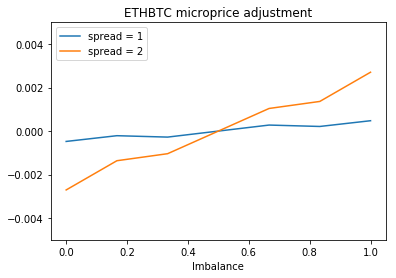

In [150]:
G6=plot_Gstar(ticker,G1,B,T)

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,1,u'ETHBTC microprice vs. empirical,spread=2')

Text(0.5,0,u'Imbalance')

Text(0.5,1,u'ETHBTC microprice vs. empirical,spread=2')

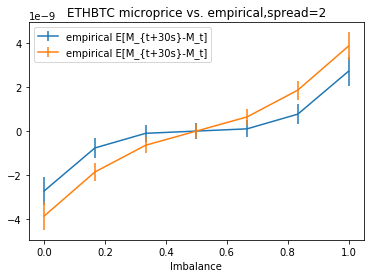

In [151]:
dt = 30
test['dM']=test['mid'].shift(dt)-test['mid']
test['dW']=test['wmid'].shift(dt)-test['mid']
grouped=test.groupby(['spread','imb_bucket'])
test['dt']=(test['EventTime'].shift(-dt)-test['EventTime'])

grouped=test.groupby(['spread','imb_bucket'])
res1min=grouped['dM'].aggregate(np.mean)
std1=grouped['dM'].aggregate(np.std)
cnt1=grouped.count()['dM']

grouped2=test.groupby(['spread','imb_bucket'])
res1min2=grouped2['dW'].aggregate(np.mean)
std12=grouped2['dW'].aggregate(np.std)
cnt12=grouped2.count()['dW']

i =1
plt.figure()
#plt.scatter(imb,g_star[(0+i*n_imb):(n_imb+i*n_imb)],label="G_star",color='r',s=50)
plt.errorbar(imb,res1min[(0+i*n_imb):(n_imb+i*n_imb)],yerr=np.sqrt(dt)*std1[(0+i*n_imb):(n_imb+i*n_imb)]/np.sqrt(cnt1[(0+i*n_imb):(n_imb+i*n_imb)]), capthick=5,label='empirical E[M_{t+'+str(dt)+'s}-M_t]')

plt.errorbar(imb,res1min2[(0+i*n_imb):(n_imb+i*n_imb)],yerr=np.sqrt(dt)*std12[(0+i*n_imb):(n_imb+i*n_imb)]/np.sqrt(cnt12[(0+i*n_imb):(n_imb+i*n_imb)]), capthick=5,label='empirical E[M_{t+'+str(dt)+'s}-M_t]')
plt.legend(loc='upper left')
plt.title(ticker+' microprice vs. empirical,spread='+str(i+1))
plt.xlabel('Imbalance')
plt.title(ticker+' microprice vs. empirical,spread='+str(i+1))


